In [0]:
# following this banana https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c03_exercise_flowers_with_data_augmentation.ipynb#scrollTo=a-AL030LmcdD
import os
import numpy as np
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(
    origin = _URL,
    fname="flower_photos.tgz",
    extract=True
)
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
# print(os.path.dirname(zip_file))
print(base_dir)
%ls $base_dir  #ls that dir just to make sure

228818944/228813984 [==============================] - 3s 0us/step
/root/.keras/datasets/flower_photos
daisy/  dandelion/  LICENSE.txt  roses/  sunflowers/  tulips/


In [3]:
### This code below splits data into training, and validation folders, each of the 2 foldesr 
### has 5 folders for each flower type. We want 80% of the photos in train dir and 20% in val

classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

for cls in classes:
  img_path = os.path.join(base_dir, cls )
  images = glob.glob(img_path + '/*.jpg')
  num_imgs = len(images)
  print('{}: {} Images'.format(cls, num_imgs))
  eighty_percent = round(num_imgs * 0.8) 
  train = images[ : eighty_percent ] 
  val = images[eighty_percent : ]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cls)):
      os.makedirs(os.path.join(base_dir, 'train', cls))
    shutil.move(t, os.path.join(base_dir, 'train', cls))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cls)):
      os.makedirs(os.path.join(base_dir, 'val', cls))
    shutil.move(v, os.path.join(base_dir, 'val', cls))




roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [0]:
batch_size = 100
IMG_SHAPE = 150
train_dir = os.path.join(base_dir, 'train')
val_dir  = os.path.join(base_dir, 'val')

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()


Found 2935 images belonging to 5 classes.


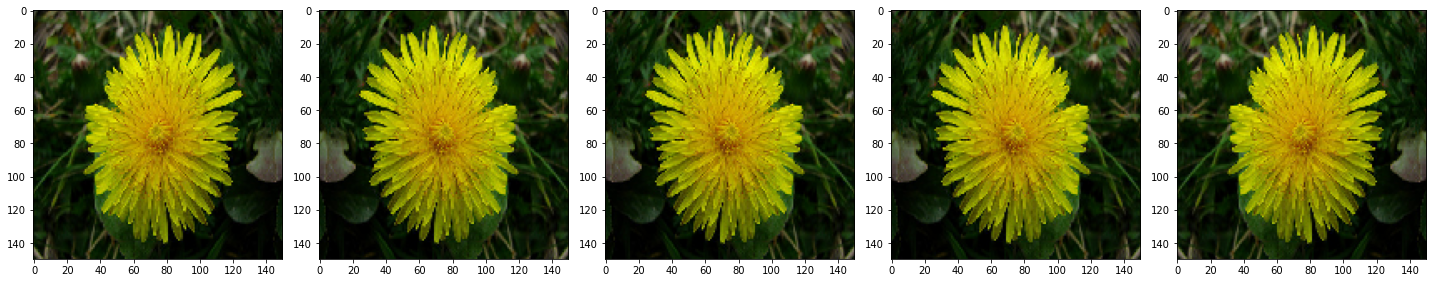

In [5]:
# horizantal flip , the flip will randomly show (or not)
image_gen = ImageDataGenerator(horizontal_flip=True, rescale=1/255)
train_data_gen = image_gen.flow_from_directory(batch_size= batch_size, directory=train_dir, shuffle=True, target_size=(IMG_SHAPE, IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2935 images belonging to 5 classes.


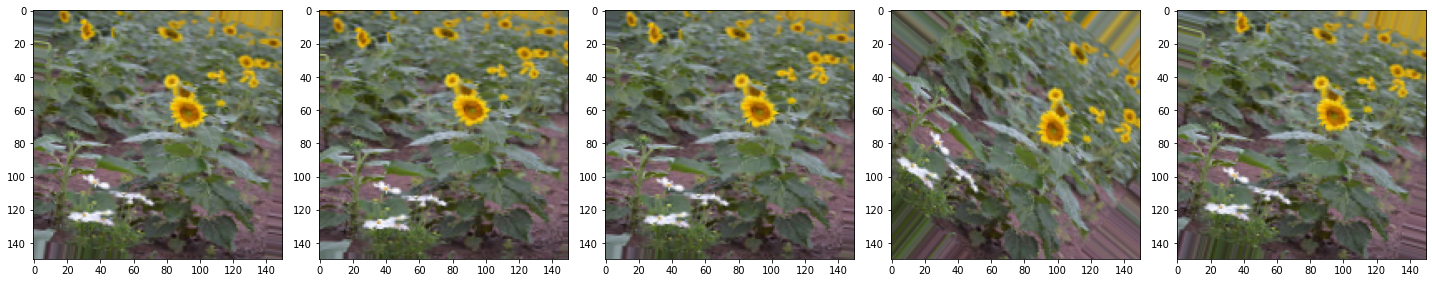

In [6]:
# random rotation
image_gen = ImageDataGenerator(rotation_range=45, rescale=1/255)
train_data_gen = image_gen.flow_from_directory(target_size=(IMG_SHAPE, IMG_SHAPE),directory=train_dir, batch_size=batch_size, shuffle=True)


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 2935 images belonging to 5 classes.


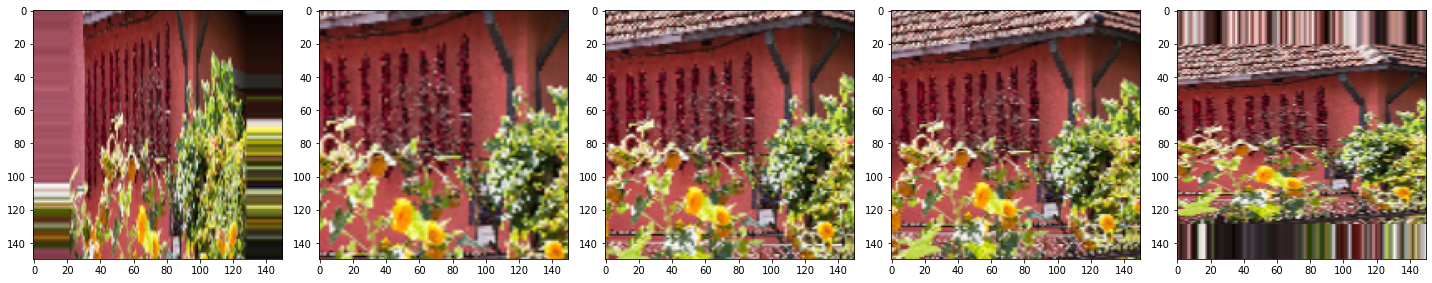

In [7]:
# zoom
image_gen = ImageDataGenerator(zoom_range=0.5, rescale=1/255)
train_data_gen = image_gen.flow_from_directory(target_size=(IMG_SHAPE, IMG_SHAPE),directory=train_dir, batch_size=batch_size, shuffle=True)


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


Found 2935 images belonging to 5 classes.


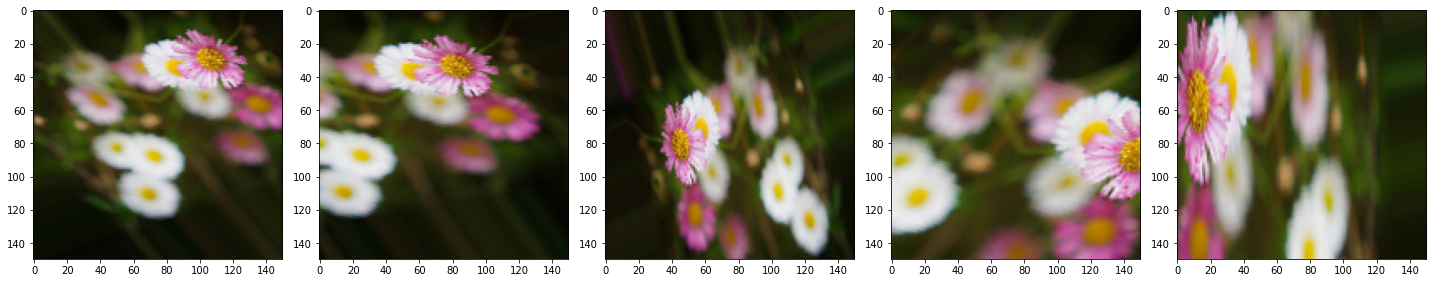

In [26]:
# Putting it all togather!!

image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [27]:
## Now to make the validation img_gen, no need for img augmenttion here as this set is
## not used for training

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


In [34]:
from functools import  partial

conv = partial(tf.keras.layers.Conv2D, activation='relu')
pool = partial(tf.keras.layers.MaxPooling2D, 2,2 )
''' Final accuracy was 
Epoch 80/80
30/30 [==============================] - 26s 881ms/step - loss: 0.3244 - accuracy: 0.8797 - val_loss: 0.8529 - val_accuracy: 0.7619'''
# model = tf.keras.models.Sequential([
#                                     conv(16, 3, input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
#                                     pool(),
                                    
#                                     conv(32, 3),
#                                     pool(),

#                                     conv(64, 3),
#                                     pool(),

#                                     tf.keras.layers.Dropout(0.2),
#                                     tf.keras.layers.Flatten(),
#                                     tf.keras.layers.Dense(512, activation='relu' ),
#                                     tf.keras.layers.Dense(5)
#                                     ])

''' With this approch (currently used accuracy was)
Epoch 80/80
30/30 [==============================] - 26s 858ms/step - loss: 0.3692 - accuracy: 0.8559 - val_loss: 0.6791 - val_accuracy: 0.7850
'''

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
model = tf.keras.models.Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 20736)           

In [35]:
epochs = 80

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/80
30/30 [==============================] - 26s 881ms/step - loss: 1.5787 - accuracy: 0.3131 - val_loss: 1.2692 - val_accuracy: 0.4585
Epoch 2/80
30/30 [==============================] - 26s 871ms/step - loss: 1.2249 - accuracy: 0.4668 - val_loss: 1.1712 - val_accuracy: 0.5156
Epoch 3/80
30/30 [==============================] - 26s 872ms/step - loss: 1.0933 - accuracy: 0.5574 - val_loss: 1.0112 - val_accuracy: 0.5878
Epoch 4/80
30/30 [==============================] - 26s 870ms/step - loss: 1.0267 - accuracy: 0.5915 - val_loss: 1.0271 - val_accuracy: 0.6299
Epoch 5/80
30/30 [==============================] - 26s 871ms/step - loss: 0.9758 - accuracy: 0.6072 - val_loss: 0.9266 - val_accuracy: 0.6531
Epoch 6/80
30/30 [==============================] - 26s 873ms/step - loss: 0.9280 - accuracy: 0.6303 - val_loss: 0.9814 - val_accuracy: 0.6136
Epoch 7/80
30/30 [==============================] - 26s 871ms/step - loss: 0.8919 - accuracy: 0.6467 - val_loss: 0.8872 - val_accuracy: 0.6503

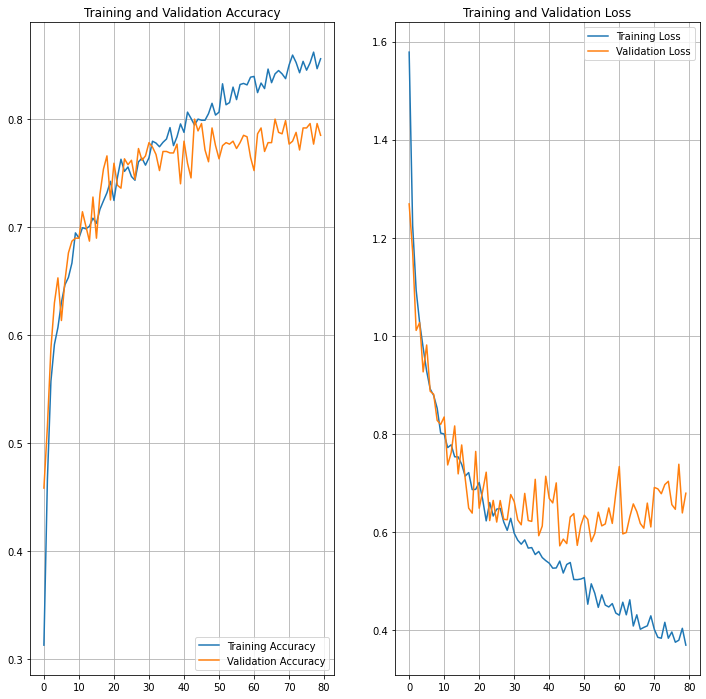

In [40]:
## now plot the compariosn graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure( figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()
